# Table of Contents
- [STATIONARITY & TRANSFORMATIONS](#stationarity--transformations)
   - [Data Cleaning](#data-cleaning)
     - [Missing Values](#missing-values)
     - [Outliers](#outliers)
   - [STATIONARITY](#STATIONARITY)
     - [ACF and PACF functions](#acf-and-pacf-functions)


In [42]:
# import packages   
import os
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

from sklearn.ensemble import IsolationForest

# STATIONARITY & TRANSFROMATIONS

## Data Cleaning

Clean the data of outliers or breaks

### Missing Values

In [43]:
# Load data
os.chdir('.')  # Set working directory to your file's location
df = pd.read_csv('data_Naseh.csv')

# Rename columns
df.columns = ['date', 'y']

# Convert 'date' column to datetime and check its data type
df['date'] = pd.to_datetime(df['date'])
print("Data types after converting 'date':\n", df.dtypes)
print("-"*50)

# Remove time part (hour:min:sec) from 'date' column
df['date'] = df['date'].dt.date
print("Data types after removing time part from 'date':\n", df.dtypes)
print("-"*50)

# Convert 'y' column to numeric and check its data type
df['y'] = pd.to_numeric(df['y'], errors='coerce')
print("Data types after converting 'y' to numeric:\n", df.dtypes)
print("-"*50)

Data types after converting 'date':
 date    datetime64[ns]
y               object
dtype: object
--------------------------------------------------
Data types after removing time part from 'date':
 date    object
y       object
dtype: object
--------------------------------------------------
Data types after converting 'y' to numeric:
 date     object
y       float64
dtype: object
--------------------------------------------------


In [44]:
# Check for missing values
print("Missing values:\n", df.isna().sum())

# Fill missing values in 'y' using a moving average with a specified window size
window_size = 5
df['y'] = df['y'].fillna(df['y'].rolling(window=window_size, min_periods=1).mean())

# Verify that missing values are filled
print("Missing values after Moving Average:\n", df.isna().sum())

Missing values:
 date      0
y       267
dtype: int64
Missing values after Moving Average:
 date    0
y       0
dtype: int64


We can replace each missing point with the average of the rolling window around it.
this code effectively addresses breaks by identifying missing values in the y column and then filling these breaks with a smoothed estimate (moving average), thus maintaining continuity in the time series data.

### Outliers

In [45]:
# Calculate the first and third quartiles (Q1 and Q3)
Q1 = df['y'].quantile(0.25)
Q3 = df['y'].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
df['outlier_iqr'] = (df['y'] < lower_bound) | (df['y'] > upper_bound)

# Count the number of outliers detected
outliers_count = df['outlier_iqr'].sum()
print(f"Number of outliers detected: {outliers_count}")

Number of outliers detected: 0


the IQR method didn’t detect any outliers, this might suggest that the data doesn’t have extreme values based on the overall distribution. However, in time series data, outliers can sometimes be better identified using a moving statistics approach because it focuses on local deviations, which are often more relevant in time-based data.

In [46]:
# Define the rolling window size
window_size = 10

# Calculate the rolling mean and rolling standard deviation
rolling_mean = df['y'].rolling(window=window_size, center=True).mean()
rolling_std = df['y'].rolling(window=window_size, center=True).std()

# Define outliers as points beyond 3 standard deviations from the rolling mean
df['outlier_moving'] = ((df['y'] > rolling_mean + 3 * rolling_std) | 
                        (df['y'] < rolling_mean - 3 * rolling_std))

# Count the number of outliers detected
outliers_count_moving = df['outlier_moving'].sum()
print(f"Number of outliers detected with moving method: {outliers_count_moving}")

Number of outliers detected with moving method: 0


Here we compute a rolling mean and rolling standard deviation over a specified window and then flag data points that deviate significantly from the rolling mean (e.g., by more than 3 standard deviations).

In [47]:
# Train Isolation Forest
model = IsolationForest(contamination=0.01)  # Set contamination to adjust sensitivity
df['outlier_iforest'] = model.fit_predict(df[['y']]) == -1

# Count the number of outliers detected
outliers_count_iforest = df['outlier_iforest'].sum()
print(f"Number of outliers detected with Isolation Forest: {outliers_count_iforest}")

Number of outliers detected with Isolation Forest: 98


with [IsolationForest](https://scikit-learn.org/1.5/modules/generated/sklearn.ensemble.IsolationForest.html) method 98 outliers are detected. 

Isolation Forest is an unsupervised machine learning algorithm designed specifically for detecting anomalies or outliers in data. Unlike traditional statistical methods, such as the Interquartile Range (IQR) or moving averages, which can miss subtle or complex outliers, Isolation Forest excels by isolating data points through random partitioning. This approach is particularly effective in identifying anomalies in complex, high-dimensional data. Isolation Forest works by constructing multiple binary trees, known as isolation trees, where each data point is "isolated" through random splits. Points that are isolated quickly, requiring fewer splits, are considered likely anomalies. The algorithm assigns an anomaly score based on the average path length across these trees—data points with shorter average path lengths are flagged as potential outliers. Because it does not rely on distance or density measures, Isolation Forest is both efficient and adaptable to various data distributions, making it a robust choice for detecting outliers in our time series dataset.

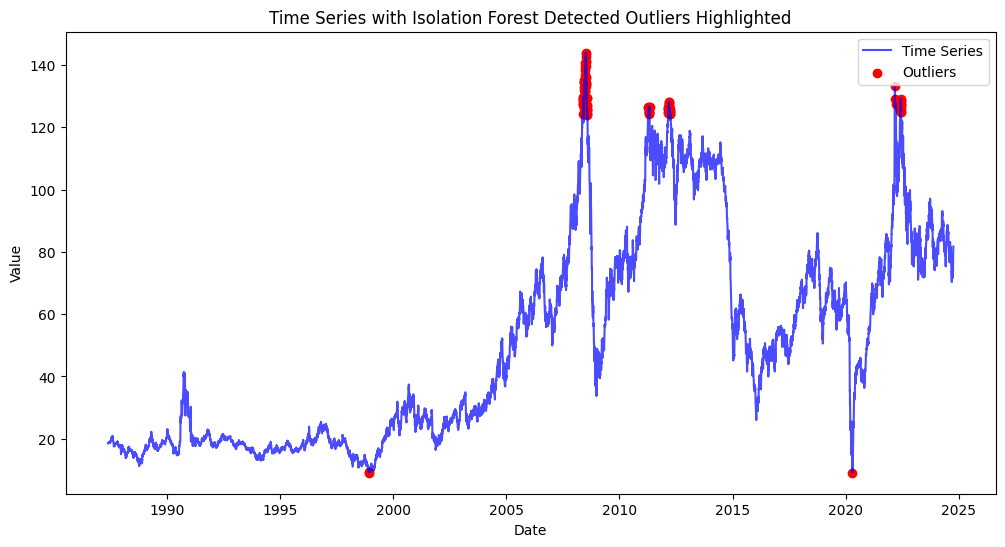

In [48]:
# Plot the entire time series
plt.figure(figsize=(12, 6))
plt.plot(df['date'], df['y'], label='Time Series', color='blue', alpha=0.7)

# Highlight detected outliers in red
plt.scatter(df['date'][df['outlier_iforest']], df['y'][df['outlier_iforest']], color='red', label='Outliers', marker='o')

# Labels and title
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Time Series with Isolation Forest Detected Outliers Highlighted')
plt.legend()
plt.show()

In [49]:
# Define a rolling window size
window_size = 5

# Replace outliers with rolling mean
df['y'] = df['y'].where(~df['outlier_iforest'], df['y'].rolling(window=window_size, min_periods=1).mean())

We replaced each outlier with the average or median of a surrounding window of values. This smooths out the effect of the outlier, maintaining the overall trend without the influence of extreme values.

## STATIONARITY

Decide and describe whether the series is stationary or not. support your argument with ACF and PACF functions, as well as statistical tests.

### ACF and PACF functions

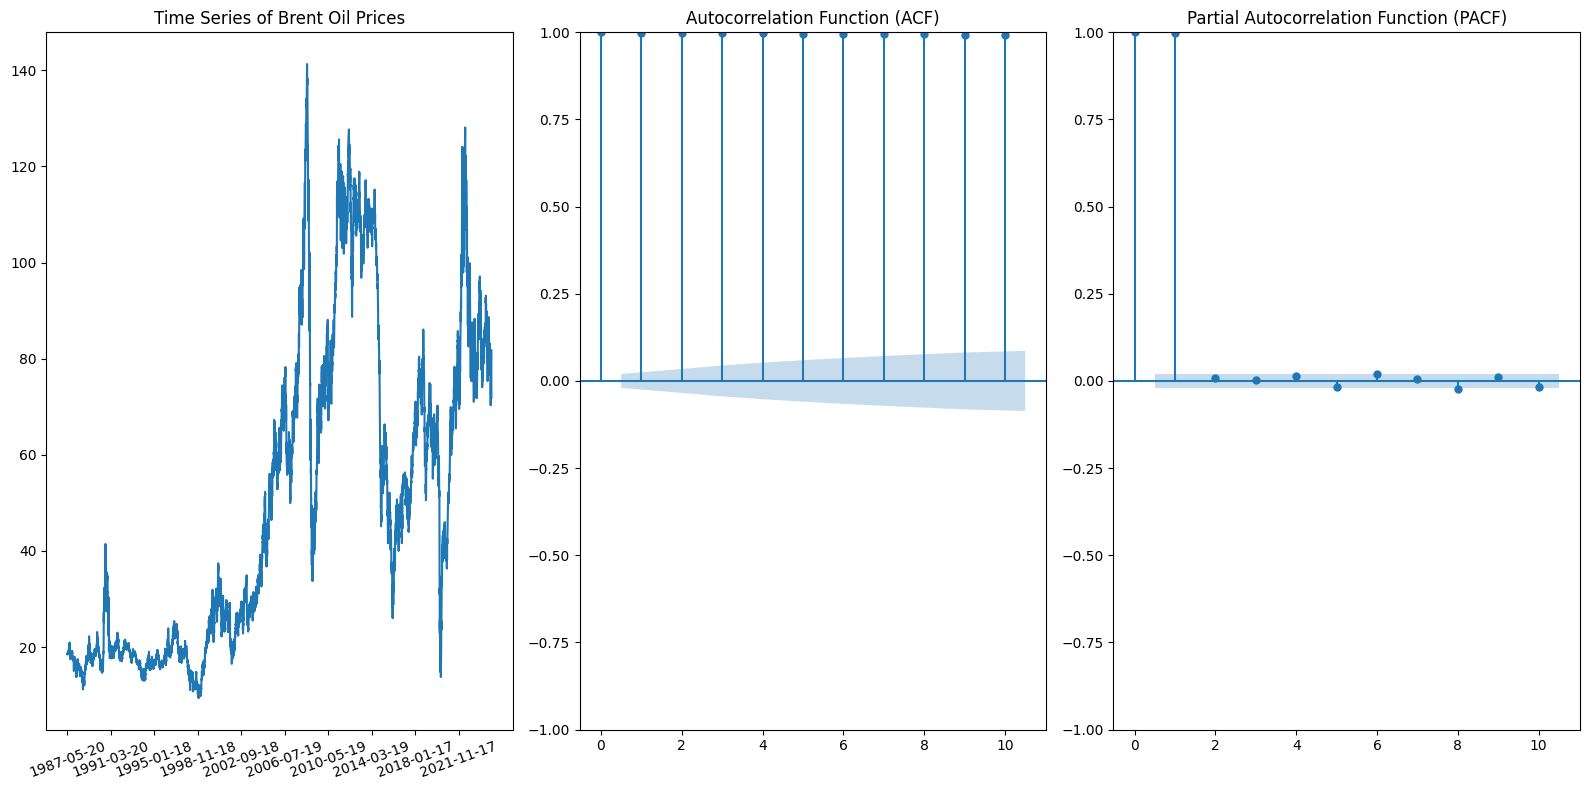

In [50]:
# Plotting
fig, axs = plt.subplots(1, 3, figsize=(16, 8))

# Plot the 'y' column (oil prices over time)
n_tick = 1000  # Number of ticks to display
axs[0].plot(df.y)

# Set x-ticks and x-tick labels
xticks = np.arange(0, len(df.y), n_tick)
axs[0].set_xticks(xticks)

# Ensure that the number of labels matches the number of ticks
xtick_labels = df.date.iloc[xticks].astype(str)  # Convert dates to strings for labeling
axs[0].set_xticklabels(xtick_labels, rotation=20)

# Set title for the first plot
axs[0].set_title('Time Series of Brent Oil Prices')

# Plot the autocorrelation function (ACF) and partial autocorrelation function (PACF)
sm.graphics.tsa.plot_acf(df.y, lags=10, ax=axs[1])
axs[1].set_title('Autocorrelation Function (ACF)')

sm.graphics.tsa.plot_pacf(df.y, lags=10, ax=axs[2])
axs[2].set_title('Partial Autocorrelation Function (PACF)')

# Adjust layout to avoid overlapping elements
plt.tight_layout()

# Show the plots
plt.show()

- **Time Series Plot:**
The time series shows clear upward and downward trends over different periods, along with noticeable peaks and troughs.
This suggests non-stationarity, as the series does not have a constant mean or variance over time.

- **Autocorrelation Function (ACF) Plot:**
The ACF plot shows significant autocorrelation at multiple lags, with slow decay. This is typical for non-stationary series, as the values are highly correlated with previous values.
Slow decay in the ACF indicates a trend or persistence over time, which reinforces the likelihood of non-stationarity.

- **Partial Autocorrelation Function (PACF) Plot:**
The PACF shows a high value at the first lag and then drops off significantly.
This pattern can sometimes suggest that the series may become stationary after differencing once, as a single significant PACF lag indicates a potential AR(1) process in a differenced series.

this series appears to be non-stationary and to make it stationary, we will apply first-order differencing. This transformation can often remove trends and stabilize the mean.
